# Get cell cycle label

2021-06-15

In [63]:
# Import Packages

%load_ext autoreload
%autoreload 2

import os
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from anndata import AnnData
from tifffile import imread
from skimage.measure import regionprops

# Customized packages
import starmap.sc_util as su

# test()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Input

In [2]:
# Set path
base_path = './'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

In [3]:
# Load adata
adata = sc.read_h5ad('./output/2021-09-24-Rena-EU-starmap-after-pp-300.h5ad')
adata

AnnData object with n_obs × n_vars = 19603 × 998
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'condition'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    layers: 'cytoplasm', 'er', 'nucleus', 'outer_cytoplasm'

In [51]:
# Assign dummy label
adata.obs['phase_ref'] = 'NA'
adata.obs['phase_new'] = 'NA'

In [52]:
# sc.pl.violin(adata, 'total_counts', groupby='sample', rotation=45)

## Subset

In [66]:
# Remove KD genes 
cdata = adata[:, 7:]
cdata

View of AnnData object with n_obs × n_vars = 19603 × 991
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'condition', 'phase_ref', 'phase_new'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    layers: 'cytoplasm', 'er', 'nucleus', 'outer_cytoplasm'

In [67]:
# Subset sample
current_sample = '20h_labeling'
cdata = cdata[cdata.obs['sample'] == current_sample, ]
cdata

View of AnnData object with n_obs × n_vars = 1427 × 991
    obs: 'orig_index', 'sample', 'volume', 'x', 'y', 'z', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_genes', 'n_counts', 'condition', 'phase_ref', 'phase_new'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'max_counts', 'n_cells'
    layers: 'cytoplasm', 'er', 'nucleus', 'outer_cytoplasm'

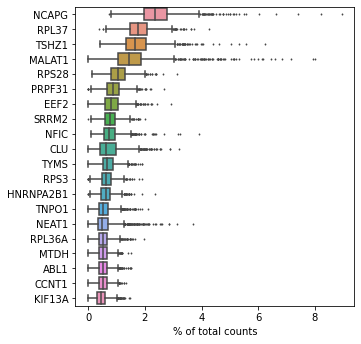

In [68]:
# Plot top 20 most expressed genes 
sc.pl.highest_expr_genes(cdata, n_top=20)

## Preprocessing

In [69]:
# Normalization scaling
sc.pp.normalize_total(cdata)
sc.pp.log1p(cdata)

# adata.layers['norm'] = adata.X
cdata.raw = cdata

# Scale data to unit variance and zero mean
sc.pp.scale(cdata)
# adata.layers['scaled'] = adata.X

## Cell cycle scoring

In [74]:
use_ref = False

if use_ref:
    # Load reference gene list 
    cell_cycle_genes = [x.strip() for x in open('./gene_modules/regev_lab_cell_cycle_genes.txt')]
    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]
else:
    # Load self defined markers 
    s_genes = pd.read_excel('./gene_modules/cell_cycle_markers.xlsx', sheet_name='G1_S', header=None)[0].to_list()
    g2m_genes = pd.read_excel('./gene_modules/cell_cycle_markers.xlsx', sheet_name='G2_M', header=None)[0].to_list()
    cell_cycle_genes = s_genes + g2m_genes

In [75]:
# Get cell cycle genes 
missed_genes = [x for x in cell_cycle_genes if x not in cdata.var_names]
cell_cycle_genes = [x for x in cell_cycle_genes if x in cdata.var_names]

print(len(cell_cycle_genes), len(missed_genes))
print(f"G1/S genes: {len(s_genes)} - G2/M genes: {len(g2m_genes)}")
print(f"G1/S genes in our dataest: {len([x for x in s_genes if x in cdata.var_names])} - G2/M genes in our dataest: {len([x for x in g2m_genes if x in cdata.var_names])}")

41 0
G1/S genes: 19 - G2/M genes: 22
G1/S genes in our dataest: 19 - G2/M genes in our dataest: 22


... storing 'phase_ref' as categorical
... storing 'phase_new' as categorical
... storing 'phase' as categorical


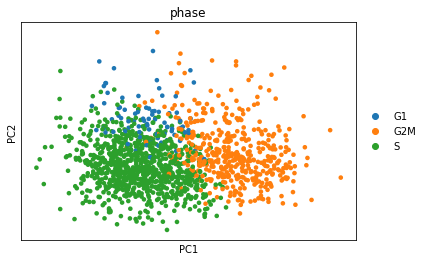

In [76]:
# Compute gene set score
sc.tl.score_genes_cell_cycle(cdata, s_genes=s_genes, g2m_genes=g2m_genes)
cdata_cc_genes = cdata[:, cell_cycle_genes]
sc.tl.pca(cdata_cc_genes)
sc.pl.pca_scatter(cdata_cc_genes, color='phase')

### Assign back to adata

In [77]:
if use_ref:
    current_column = 'phase_ref'
    adata.obs.loc[adata.obs['sample'] == current_sample, current_column] = cdata.obs['phase'].values
else:
    current_column = 'phase_new'
    adata.obs.loc[adata.obs['sample'] == current_sample, current_column] = cdata.obs['phase'].values

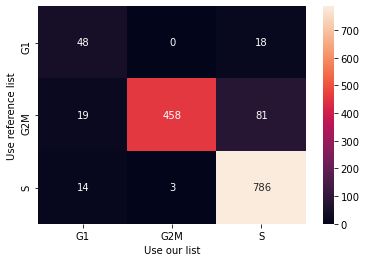

In [78]:
confusion_matrix = pd.crosstab(adata.obs.loc[adata.obs['sample'] == current_sample, 'phase_ref'], adata.obs.loc[adata.obs['sample'] == current_sample, 'phase_new'], rownames=['Use reference list'], colnames=['Use our list'])
sns.heatmap(confusion_matrix, annot=True, fmt='')
plt.show()

## Output

In [80]:
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
adata.write_h5ad(f"./output/{date}-Rena-EU-starmap-cc.h5ad")

... storing 'phase_ref' as categorical
... storing 'phase_new' as categorical


## Generate phase_ref label for all conditions

In [4]:
# Set path
base_path = './'
out_path = os.path.join(base_path, 'output')
fig_path = os.path.join(base_path, 'figures')
if not os.path.exists(fig_path):
    os.mkdir(fig_path)

# Load adata
adata = sc.read_h5ad('./output/2021-09-24-Rena-EU-starmap-after-pp-300.h5ad')
adata

# Assign dummy label
adata.obs['phase_ref'] = 'NA'

for current_sample in adata.obs['sample'].unique():
    
    # Remove KD genes 
    cdata = adata[:, 7:]
    cdata = cdata[cdata.obs['sample'] == current_sample, ]

    # Normalization scaling
    sc.pp.normalize_total(cdata)
    sc.pp.log1p(cdata)
    cdata.raw = cdata

    # Scale data to unit variance and zero mean
    sc.pp.scale(cdata)
    
    # Load reference gene list 
    cell_cycle_genes = [x.strip() for x in open('./gene_modules/regev_lab_cell_cycle_genes.txt')]
    s_genes = cell_cycle_genes[:43]
    g2m_genes = cell_cycle_genes[43:]


    # Get cell cycle genes 
    missed_genes = [x for x in cell_cycle_genes if x not in cdata.var_names]
    cell_cycle_genes = [x for x in cell_cycle_genes if x in cdata.var_names]

    # Compute gene set score
    sc.tl.score_genes_cell_cycle(cdata, s_genes=s_genes, g2m_genes=g2m_genes)

    adata.obs.loc[adata.obs['sample'] == current_sample, 'phase_ref'] = cdata.obs['phase'].values
    
# output
from datetime import datetime
date = datetime.today().strftime('%Y-%m-%d')
adata.write_h5ad(f"./output/{date}-Rena-EU-starmap-cc.h5ad")

... storing 'phase_ref' as categorical


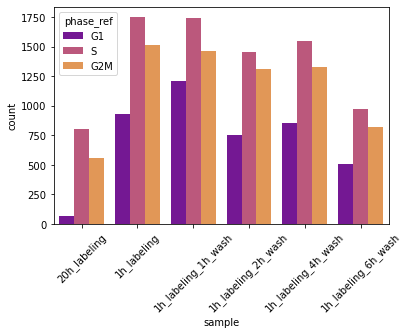

In [62]:
adata.obs['phase_ref'] = adata.obs['phase_ref'].astype('category')
adata.obs['phase_ref'] = adata.obs['phase_ref'].cat.reorder_categories(['G1', 'S', 'G2M'])
sns.countplot(x="sample", hue="phase_ref", data=adata.obs, palette='plasma')
plt.xticks(rotation=45)
plt.show()

## Test

In [226]:
from tifffile import imread
current_img = imread('./1h_labeling/segmentation/dapi.tiff')
intensity_img = imread('./1h_labeling/image/dapi.tif')

In [227]:
G1_cells = new_df.loc[new_df['phase'] == 'G1', 'orig_index'].to_list()
S_cells = new_df.loc[new_df['phase'] == 'S', 'orig_index'].to_list()
G2M_cells = new_df.loc[new_df['phase'] == 'G2M', 'orig_index'].to_list()

g1_areas = []
s_areas = []
g2m_areas = []
from skimage.measure import regionprops
for i, region in enumerate(regionprops(current_img, intensity_image=intensity_img)):
    if region.label - 1 in G1_cells:
            g1_areas.append(region.area * region.mean_intensity)
    elif region.label - 1 in S_cells:
        s_areas.append(region.area* region.mean_intensity)
    elif region.label - 1 in G2M_cells:
        g2m_areas.append(region.area* region.mean_intensity)

<AxesSubplot:ylabel='Density'>

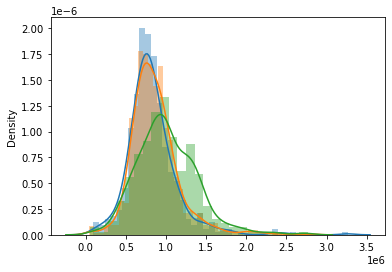

In [228]:
sns.distplot(g1_areas)
sns.distplot(s_areas)
sns.distplot(g2m_areas)

In [229]:
total_areas = g1_areas + s_areas + g2m_areas
total_phase = ['G1'] * len(g1_areas) + ['S'] * len(s_areas) + ['G2M'] * len(g2m_areas)
df = pd.DataFrame({'phase': total_phase, 'value': total_areas})
df
# sns.violinplot(g1_areas)

,phase,value
0,G1,699308.0
1,G1,786763.0
2,G1,836241.0
3,G1,867309.0
4,G1,891101.0
...,...,...
2137,G2M,1504986.0
2138,G2M,497511.0
2139,G2M,606366.0
2140,G2M,866446.0


<AxesSubplot:xlabel='phase', ylabel='value'>

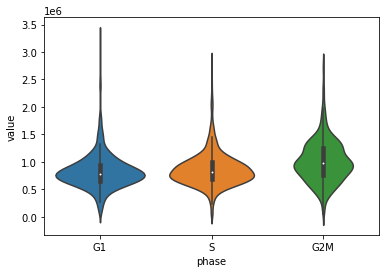

In [230]:
sns.violinplot(x='phase', y='value', data=df)